In [48]:
import sys
sys.path.append('../..')

In [49]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image, ImageOps

import torch
from torch.utils.data import Dataset
from torchvision import transforms

from src.tool.registry import DATASET_REGISTRY

# @DATASET_REGISTRY.register()
class Pedar_Dataset_footprint2pressure(Dataset):
    def __init__(
            self: str,
            footprint_wrap_folder: str = '../../data/processed/footprint-wrap',
            pedar_dynamic: str = '../../data/processed/pedar_dynamic.pkl',
            l_mask_path: str = 'config/left_foot_mask.png',
            sense_range: float = 600,
            stack_range: int = 50,
            dtype = torch.float32,
            ):
        self.footprint_wrap_folder = Path(footprint_wrap_folder)
        self.pedar_dynamic = pd.read_pickle(pedar_dynamic)
        self.dtype = dtype
        self.sense_range = sense_range
        self.stack_range = stack_range

        self.load_foot_mask(l_mask_path)
        
        # youngs modulus (MPa)
        self.material_youngs = {
            'Poron': 0.33,
            'PElite': 1.11,
            'Lunalight': 5.88,
            'Lunanastik': 0.71,
            'BF': 0.00,
        }

        # subjects list as index
        self.index = []

        for subject in self.pedar_dynamic.index.get_level_values(1).drop_duplicates():
            if os.path.isfile(self.footprint_wrap_folder / f'{subject}-L.jpg'):
                self.index.append(subject)

    def load_foot_mask(self, l_mask_path: str):
        # load foot masks
        l_img = Image.open(l_mask_path)
        r_img = ImageOps.mirror(l_img)

        self.l_mask = np.array(l_img).astype(np.float64)
        self.r_mask = np.array(r_img).astype(np.float64)

        # detect pixels of area no.1~197 and store the corresponding indexes
        self.l_index = {}
        self.r_index = {}

        for n in range(0, 99):
            self.l_index[n] = np.where(self.l_mask == n + 1)
            self.r_index[n + 99] = np.where(self.r_mask == n + 1)

        # index grids for slicing footprint image as sensor stacks
        range_half = int(self.stack_range / 2)

        self.x_grid = {'L': [], 'R': []}
        self.y_grid = {'L': [], 'R': []}

        for sensor in range(99):
            x_center, y_center = int(self.l_index[sensor][0].mean()), int(self.l_index[sensor][1].mean())
            xs = np.arange(x_center - range_half, x_center + range_half)
            ys = np.arange(y_center - range_half, y_center + range_half)
            xg, yg = np.meshgrid(xs, ys, indexing='ij')
            self.x_grid['L'].append(xg)
            self.y_grid['L'].append(yg)

        for sensor in range(99, 198):
            x_center, y_center = int(self.r_index[sensor][0].mean()), int(self.r_index[sensor][1].mean())
            xs = np.arange(x_center - range_half, x_center + range_half)
            ys = np.arange(y_center - range_half, y_center + range_half)
            xg, yg = np.meshgrid(xs, ys, indexing='ij')
            self.x_grid['R'].append(xg)
            self.y_grid['R'].append(yg)

    def __len__(self):
        return len(self.index)
    
    def __getitem__(self, index: int, blend_weight: np.array = None) -> tuple:
        if blend_weight is None:
            blend_weight = np.random.rand(5)
            blend_weight = blend_weight / blend_weight.sum()

        # get subject
        subject = self.index[index]
        
        # weight blends young modulus & pedar arrays
        arr_pedar = self.pedar_dynamic.loc[:, subject, :].values / self.sense_range
        blend_pedar = torch.tensor(
            (arr_pedar * np.expand_dims(blend_weight, axis=-1)).sum(axis=0),
            dtype=self.dtype,
            )
        blend_young = torch.tensor(
            (np.array(list(self.material_youngs.values())) * blend_weight).sum(),
            dtype=self.dtype,
            )

        # load footprint image and slice as per-sensor stacks
        def get_img_stack(foot: str):
            img = Image.open(self.footprint_wrap_folder / f'{subject}-{foot}.jpg')
            img_arr = np.mean(1 - np.array(img).astype(np.float64) / 255, axis=-1)
            img_stack = img_arr[self.x_grid[foot], self.y_grid[foot]]
            img_stack = torch.tensor(img_stack, dtype=self.dtype)
            img_stack = transforms.Resize((10, 10))(img_stack)
            return img_stack
        
        l_stack = get_img_stack('L')
        r_stack = get_img_stack('R')
        img_stack = torch.concat([l_stack, r_stack])

        return (img_stack, blend_young), blend_pedar

In [50]:
from src.tool.registry import DATASET_REGISTRY

self = Pedar_Dataset_footprint2pressure(
    footprint_wrap_folder = '../../data/processed/footprint-wrap',
    pedar_dynamic = '../../data/processed/pedar_dynamic.pkl',
    l_mask_path = '../../data/processed/left_foot_mask.png',
)
len(self)

50

In [51]:
(sensor_stack, youngs_modulus), arr_pedar = self.__getitem__(3)
youngs_modulus

tensor(1.6202)

torch.Size([198, 10, 10])


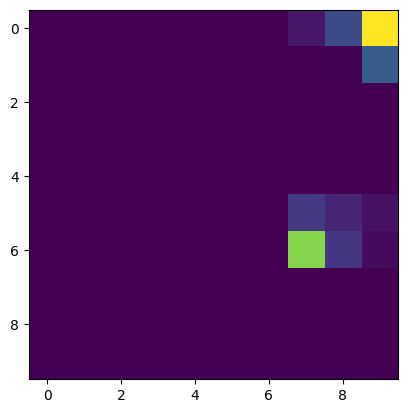

In [56]:
from matplotlib import pyplot as plt

print(sensor_stack.shape)
plt.imshow(sensor_stack[99].cpu().detach().numpy())
plt.show()

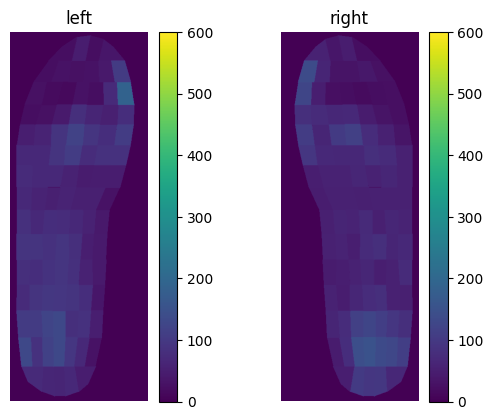

In [57]:
from src.tool import visual

visual.draw_heatmap(arr_pedar * 600, '../../data/processed/left_foot_mask.png')